In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchsummary import summary
from transformers import ViTModel, ViTConfig, ViTForImageClassification
from torchvision import transforms


# set the path to the directory containing the npy files
data_dir = '/home/tejasri/Desktop/eurosat-ms/rgb_npy'

# set the path to save the trained model
model_path = '/home/tejasri/Desktop/eurosat-ms/EuroSAT-RGB'

# load the X and y data for each class
X = []
y = []
for i in range(10):
    X_i = np.load(f'{data_dir}/X{i}.npy')
    y_i = np.load(f'{data_dir}/y{i}.npy')
    X.append(X_i)
    y.append(y_i)

# concatenate the X and y data for all classes
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)





2023-05-30 17:21:51.943954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 17:21:52.524216: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-30 17:21:52.524261: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-30 17:21:52.524266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
import einops
print(X.shape)
print(y.shape)




(27000, 64, 64, 3)
(27000,)


In [3]:
X = einops.rearrange(X, 'b h w c -> b c h w')
              
print(X.shape)

print(X[0].shape)


(27000, 3, 64, 64)
(3, 64, 64)


In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
# split the data into training and testing sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# split the data
for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]




In [6]:
print(X_test.shape)

(5400, 3, 64, 64)


In [7]:
# define a custom dataset class for the EuroSAT multispectral data
class EuroSATDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# create data loaders for the training and testing sets
train_dataset = EuroSATDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = EuroSATDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# set the device to use for training and testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
print(len(train_loader))

675


In [9]:
print(len(test_loader))

169


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Vit blocks

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x
    


In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    


In [14]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [15]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [16]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [17]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])
                

In [18]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [19]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768, 
                img_size: int = 64,
                depth: int = 12,
                n_classes: int = 10,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        

In [20]:
summary(ViT().cuda(), (3, 64, 64), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 4, 4]         590,592
         Rearrange-2              [-1, 16, 768]               0
    PatchEmbedding-3              [-1, 17, 768]               0
         LayerNorm-4              [-1, 17, 768]           1,536
            Linear-5             [-1, 17, 2304]       1,771,776
           Dropout-6            [-1, 8, 17, 17]               0
            Linear-7              [-1, 17, 768]         590,592
MultiHeadAttention-8              [-1, 17, 768]               0
           Dropout-9              [-1, 17, 768]               0
      ResidualAdd-10              [-1, 17, 768]               0
        LayerNorm-11              [-1, 17, 768]           1,536
           Linear-12             [-1, 17, 3072]       2,362,368
             GELU-13             [-1, 17, 3072]               0
          Dropout-14             [-1, 1

In [21]:
model = ViT()
model=model.cuda()

In [22]:

import torch.optim as optim
from tqdm import tqdm

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10


In [23]:
print(torch.cuda.is_available())

True


In [24]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)
    
    model.train()
    running_loss=0
    correct=0
    total=0

    for images, labels in tqdm(train_loader):
        
        images = images.float().cuda()
        labels = labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))
        
        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)
        
        
       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
    #Replaces pow(2.0) with abs() for L1 regularization
    
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm
    
        
        running_loss += loss.item()
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
  
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    

In [25]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            labels = labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)
            
            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()
            
            
           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
    

In [26]:
import time
epochs = 30

# Start the timer

start_time = time.time()
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))


Epoch : 1


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.94it/s]


Train Loss: 1.722 | Accuracy: 35.759


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 53.78it/s]


Test Loss: 1.427 | Accuracy: 47.148
Epoch : 2


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.91it/s]


Train Loss: 1.333 | Accuracy: 51.509


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 53.95it/s]


Test Loss: 1.204 | Accuracy: 57.130
Epoch : 3


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.88it/s]


Train Loss: 1.316 | Accuracy: 52.894


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.22it/s]


Test Loss: 1.110 | Accuracy: 59.685
Epoch : 4


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.91it/s]


Train Loss: 1.176 | Accuracy: 58.204


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.22it/s]


Test Loss: 1.590 | Accuracy: 43.500
Epoch : 5


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.87it/s]


Train Loss: 1.209 | Accuracy: 56.856


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 53.99it/s]


Test Loss: 1.051 | Accuracy: 60.852
Epoch : 6


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.91it/s]


Train Loss: 1.035 | Accuracy: 62.523


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.23it/s]


Test Loss: 1.038 | Accuracy: 62.259
Epoch : 7


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.91it/s]


Train Loss: 0.969 | Accuracy: 65.019


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.08it/s]


Test Loss: 0.954 | Accuracy: 65.111
Epoch : 8


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.90it/s]


Train Loss: 0.925 | Accuracy: 66.648


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 53.95it/s]


Test Loss: 0.863 | Accuracy: 68.574
Epoch : 9


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.91it/s]


Train Loss: 0.935 | Accuracy: 66.523


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.22it/s]


Test Loss: 1.423 | Accuracy: 49.407
Epoch : 10


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.91it/s]


Train Loss: 0.900 | Accuracy: 67.736


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.29it/s]


Test Loss: 0.882 | Accuracy: 68.389
Epoch : 11


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.94it/s]


Train Loss: 0.864 | Accuracy: 69.134


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.94it/s]


Test Loss: 0.786 | Accuracy: 70.741
Epoch : 12


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.03it/s]


Train Loss: 0.973 | Accuracy: 65.394


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.77it/s]


Test Loss: 0.861 | Accuracy: 67.815
Epoch : 13


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.96it/s]


Train Loss: 1.051 | Accuracy: 62.120


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.44it/s]


Test Loss: 0.924 | Accuracy: 67.648
Epoch : 14


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.02it/s]


Train Loss: 0.914 | Accuracy: 67.375


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 55.11it/s]


Test Loss: 0.885 | Accuracy: 68.833
Epoch : 15


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.04it/s]


Train Loss: 0.871 | Accuracy: 68.894


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 55.26it/s]


Test Loss: 0.928 | Accuracy: 65.852
Epoch : 16


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.06it/s]


Train Loss: 0.969 | Accuracy: 65.968


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 55.12it/s]


Test Loss: 1.453 | Accuracy: 46.611
Epoch : 17


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.02it/s]


Train Loss: 1.126 | Accuracy: 60.296


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 53.66it/s]


Test Loss: 0.944 | Accuracy: 66.481
Epoch : 18


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.82it/s]


Train Loss: 0.931 | Accuracy: 66.699


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.28it/s]


Test Loss: 0.864 | Accuracy: 69.648
Epoch : 19


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.00it/s]


Train Loss: 1.178 | Accuracy: 58.736


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 55.12it/s]


Test Loss: 1.242 | Accuracy: 55.759
Epoch : 20


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.00it/s]


Train Loss: 1.023 | Accuracy: 63.639


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.96it/s]


Test Loss: 0.901 | Accuracy: 67.796
Epoch : 21


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.00it/s]


Train Loss: 0.892 | Accuracy: 67.657


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.31it/s]


Test Loss: 0.886 | Accuracy: 68.093
Epoch : 22


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.00it/s]


Train Loss: 0.891 | Accuracy: 67.972


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.38it/s]


Test Loss: 0.824 | Accuracy: 70.481
Epoch : 23


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.00it/s]


Train Loss: 0.878 | Accuracy: 68.718


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.93it/s]


Test Loss: 0.789 | Accuracy: 71.130
Epoch : 24


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.96it/s]


Train Loss: 0.880 | Accuracy: 69.102


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.97it/s]


Test Loss: 1.548 | Accuracy: 49.111
Epoch : 25


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.01it/s]


Train Loss: 0.798 | Accuracy: 71.282


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.84it/s]


Test Loss: 0.750 | Accuracy: 73.111
Epoch : 26


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.01it/s]


Train Loss: 0.791 | Accuracy: 71.727


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.98it/s]


Test Loss: 0.732 | Accuracy: 73.426
Epoch : 27


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.01it/s]


Train Loss: 0.757 | Accuracy: 72.741


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.87it/s]


Test Loss: 0.737 | Accuracy: 72.519
Epoch : 28


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.01it/s]


Train Loss: 0.978 | Accuracy: 65.366


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.85it/s]


Test Loss: 0.880 | Accuracy: 67.241
Epoch : 29


100%|█████████████████████████████████████████| 675/675 [00:51<00:00, 13.01it/s]


Train Loss: 0.854 | Accuracy: 69.403


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 53.74it/s]


Test Loss: 0.756 | Accuracy: 72.130
Epoch : 30


100%|█████████████████████████████████████████| 675/675 [00:52<00:00, 12.97it/s]


Train Loss: 0.863 | Accuracy: 69.190


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.82it/s]

Test Loss: 1.333 | Accuracy: 52.889
Training time: 1655.30 seconds


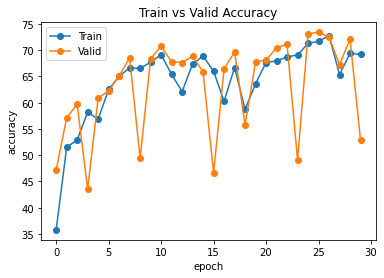

In [30]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

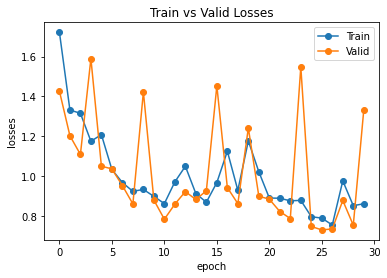

In [31]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [32]:
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score

# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for (X_val, y_val) in tqdm(test_loader):
        X_val = X_val.float().cuda()
        y_val = y_val.float().cuda()
        #X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)
        
        output = model(X_val)
        #print(output.shape)
        
        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)
    
    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)
    
    
# with torch.no_grad():
#     model.eval()
#     for id, (X_val, y_val) in enumerate(val_data):
#         X_val, y_val = X_val.to(device), y_val.to(device)
#         y_val = y_val.type(torch.cuda.LongTensor)
        
#         output = model(X_val)
#         outputs = torch.max(output, dim=1)[1]
#         T_val.extend(y_val.cpu().numpy())
#         P_val.extend(outputs.cpu().numpy())
#     print(T_val)
#     print(P_val)
#     precision = precision_score(T_val, P_val, average='macro')
#     recall = recall_score(T_val, P_val, average='macro')
#     res = confusion_matrix(T_val, P_val)
#     report = classification_report(T_val, P_val)
    
#     print("Precision: ",precision)
#     print("Recall: ",recall)

#     print('Confusion matrix:\n',res)
#     print('Report:\n',report)

100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 54.40it/s]

Precision:  0.5583674971129337
Recall:  0.5283666666666667
Confusion matrix:
 [[415   0   5  11  13  15 123  16   1   1]
 [  1 349 175   0   0  60   0   2   1  12]
 [ 21   0 264  26  39  14 194  37   5   0]
 [ 39   0  87  30  93  31 121  90   9   0]
 [  2   0   0   2 487   0   2   7   0   0]
 [  1   1  24   0  69 248  41  13   3   0]
 [ 27   0  29  15  21  13 359  36   0   0]
 [ 29   0  42  27  70   5  82 345   0   0]
 [ 10   5  98  25  95  37  44 111  75   0]
 [  3 133  73   1   1  34   6  44  21 284]]
Report:
               precision    recall  f1-score   support

         0.0       0.76      0.69      0.72       600
         1.0       0.72      0.58      0.64       600
         2.0       0.33      0.44      0.38       600
         3.0       0.22      0.06      0.09       500
         4.0       0.55      0.97      0.70       500
         5.0       0.54      0.62      0.58       400
         6.0       0.37      0.72      0.49       500
         7.0       0.49      0.57      0.53      